<h1 style="text-align:center;">Workshop Training</h1> 

<h2 style="text-align:center;">LULC Analysis and Classification using Remote Sensing Data with Machine Learning Approach</h2> 

### Section 4: Inferencing and Application

This session is to learn about how the multi-temporal of index images is constructed and preprocesed to be ready-to-analysis for inferenceing the results to produce LULC map


In [ ]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import rasterio
from glob import glob

import pandas as pd
import re

 import requests
 import json


we have prepared the dataset within `inference_dataset` path alrealy. Do not forget to define base_path to be git repository or local. Additional labels will be decalre for better intuition

In [70]:
#base_path = ''
base_path = 'https://github.com/thanthamky/rs-lc-dl/raw/refs/heads/main/'

dataset_path = 'inference_dataset'

rs_index_type = ['ndvi', 'evi', 'savi', 'ndwi', 'vva', 'vvd', 'vha', 'vhd']
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

You may examine the dataset path to understand how the image files arranged. Noted that this image files are likely placed in same pattern with the common LULC Classification workflow

Next, to retrieve the image file order, there should be some function to re-arrange the image as defined

In [71]:
def numeric_sort_key(file):
    base_name = file.split('/')[-1]
    match = re.match(r"(\d+)_.*", base_name)
    return int(match.group(1)) if match else float('inf')

Apply the function to searching for the files and save to Dictionary variable

In [78]:
index_file = {}

for index_type in rs_index_type:
    
    if base_path == '':
        
        file_list = glob(dataset_path+'/'+index_type+'/*.tif')
        index_file[index_type] = sorted(file_list, key=numeric_sort_key)
        
    else:
        index_file = eval(requests.get(base_path+'inference_dataset_gitpath.json').text)
    
    

If check the result, there are files of each image paths heading by month numbers. And, some month has no image in that period. This will be preprocessed to fill it later

The list of images will be read and retrieved image data array from files. Missing periods will be filled with Nodata (zero) map. This code is to demonstrate to show only how first data (NDVI) is constructed

In [79]:
ndvi_cube = {}

for file in index_file['ndvi']:
    
    month_index = int(file.split('/')[-1].split('_')[0])
    
    with rasterio.open(file) as src:
        
        ndvi_cube[month_index] = src.read(1)
        
        height, width = src.read(1).shape
        
for month_i in months:
    
    if month_i not in ndvi_cube:
        ndvi_cube[month_i] = np.zeros((height, width))
        
ndvi_cube = dict(sorted(ndvi_cube.items()))

If check the NDVI datacube, it is a dictionary of each month key and numpy array data for that month

In [80]:
ndvi_cube

{1: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 2: array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.22753906,  0.21704102, ...,  0.44262695,
          0.45043945,  0.39526367],
        [ 0.        ,  0.1998291 ,  0.2454834 , ...,  0.41625977,
          0.46679688,  0.43823242],
        ...,
        [ 0.        , -0.18005371, -0.21252441, ...,  0.34643555,
          0.37841797,  0.38378906],
        [ 0.        , -0.16369629, -0.17126465, ...,  0.3059082 ,
          0.34521484,  0.32055664],
        [ 0.        , -0.15466309, -0.16247559, ...,  0.32226562,
          0.3010254 ,  0.34228516]], dtype=float32),
 3: array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]

All month data occupied by dictionary variable. It should be re-constructed to multi-dimensional numap array to 3-D (height, width, month) shape. We can use `np.dstack` or do dimensional stacking

In [81]:
ndvi_cube = np.dstack(ndvi_cube.values())

Check the shape

In [82]:
ndvi_cube.shape

(390, 422, 12)

To show a time-serie of a single pixel, we can call the datacube by [row_idx, col_idx, month_idx] as example

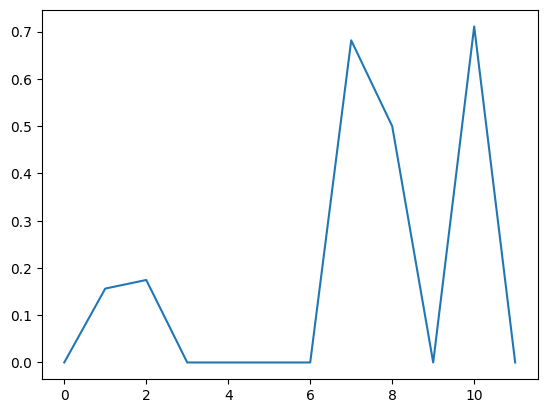

In [18]:
plt.plot(ndvi_cube[300, 400, :])

We filled `0` (zero) to be in missing data. It should be droped and re-fill again by interpolation method. Then, declare the function to do

In [83]:
def interpolate_zeros(arr):

    non_zero_indices = np.nonzero(arr)[0]
    non_zero_values = arr[non_zero_indices]

    zero_indices = np.where(arr == 0)[0]

    interpolated_values = np.interp(zero_indices, non_zero_indices, non_zero_values)

    arr[zero_indices] = interpolated_values

    return arr

Visualize the Result

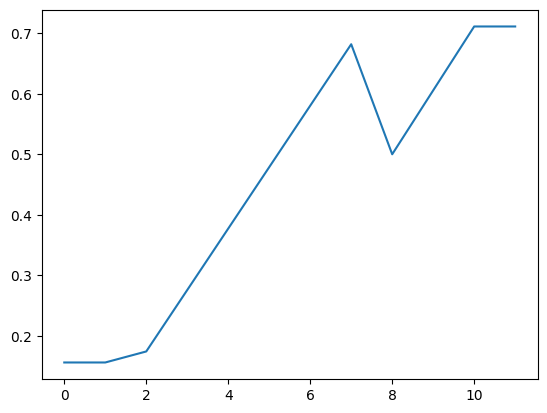

In [84]:
plt.plot(interpolate_zeros(ndvi_cube[300, 400, :]))

Although interpolated time-serie is fulfilled, It is not smooth. We also should smoothen it for local variation removal. Then, declare the function

In [85]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=0.4, order=4):
    b, a = butter(order, cutoff, btype='low')
    smoothed_data = filtfilt(b, a, data, padlen=3)
    return smoothed_data

Try to apply it and visualize the result

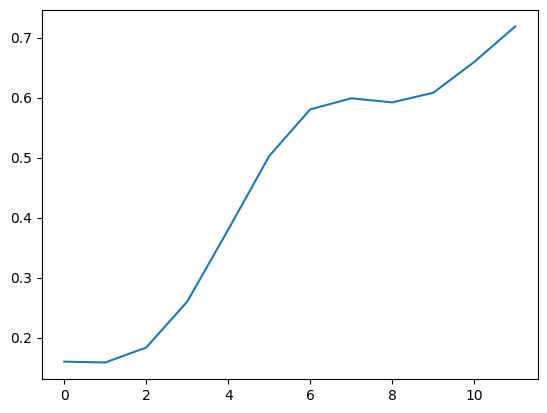

In [86]:
plt.plot(butter_lowpass_filter(interpolate_zeros(ndvi_cube[300, 400, :])))

Preprocesing tools were prepared in advance to perform with a single pixel in a row of temporal axis. To implement this, we raise the example pixel index location of each LULC type to examine the result in order to do Exploratory Data Analysis (EDA) to check the time-series

In [87]:
water_row_col = (358, 16)
urban_row_col = (377, 314)
forest_row_col = (318, 264)
crop_row_col = (264, 174)

There are 2 functions including interpolation and smoothing time-serie of a single pixel row. We would come up the simple lambda function to make a preprocessor

In [88]:
preprocess_timeseries = lambda x: butter_lowpass_filter(interpolate_zeros(x))

For more visual investigation, perform preprocessing on-the-fly with specific pixels defined with plot

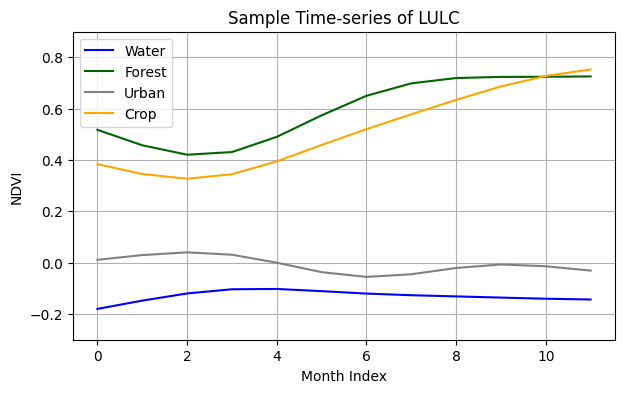

In [89]:
plt.figure(figsize=(7, 4))


plt.plot(preprocess_timeseries(ndvi_cube[ water_row_col[0], water_row_col[1], :]), color='blue', label='Water')
plt.plot(preprocess_timeseries(ndvi_cube[ forest_row_col[0], forest_row_col[1], :]), color='darkgreen', label='Forest')
plt.plot(preprocess_timeseries(ndvi_cube[ urban_row_col[0], urban_row_col[1], :]), color='gray', label='Urban')
plt.plot(preprocess_timeseries(ndvi_cube[ crop_row_col[0], crop_row_col[1], :]), color='orange', label='Crop')

plt.ylim(-0.3, 0.9)
plt.grid()

plt.xlabel('Month Index')
plt.ylabel('NDVI')

plt.title('Sample Time-series of LULC')

plt.legend()
plt.show()


Perviously, we perform data preparation and preprocesing only with a single datacube. It is time to perform for all index images for 8 features. Declare the function to make raw data cube

In [90]:
def create_datacube(raster_list):
    
    raster_cube = {}

    for file in raster_list:
        
        month_index = int(file.split('/')[-1].split('_')[0])
        
        with rasterio.open(file) as src:
            
            raster_cube[month_index] = src.read(1)
            
            height, width = src.read(1).shape
            
    for month_i in months:
        
        if month_i not in raster_cube:
            raster_cube[month_i] = np.zeros((height, width))
            
    raster_cube = dict(sorted(raster_cube.items()))
    
    return np.dstack(raster_cube.values())

Listing the datacube in a row of the given index list

In [92]:
datacube_list = [create_datacube(index_file[index]) for index in index_file.keys()]
len(datacube_list)

KeyboardInterrupt: 

Stack the list of datacube to be 4-D dataset corresponding to (height, width, month, feature)

In [93]:
datacube = np.stack(datacube_list, axis=3)

datacube.shape

(390, 422, 12, 8)

This dataset is not preprocessed yet, even though there are many ways to perform it faster, we would implment in simlpest and intuitive way for more understanding

In [94]:
for i in tqdm(range(datacube.shape[0])):
    
    for j in range(datacube.shape[1]):
        
        for k in range(datacube.shape[3]):
            
            try:
                new_pixel_timeseries = preprocess_timeseries(datacube[i, j, :, k])
            except:
                new_pixel_timeseries = np.zeros((datacube.shape[2]))
            
            datacube[i, j, :, k] = new_pixel_timeseries

  0%|          | 0/390 [00:00<?, ?it/s]

100%|██████████| 390/390 [04:41<00:00,  1.39it/s]


Try to plot them through monthly scenes

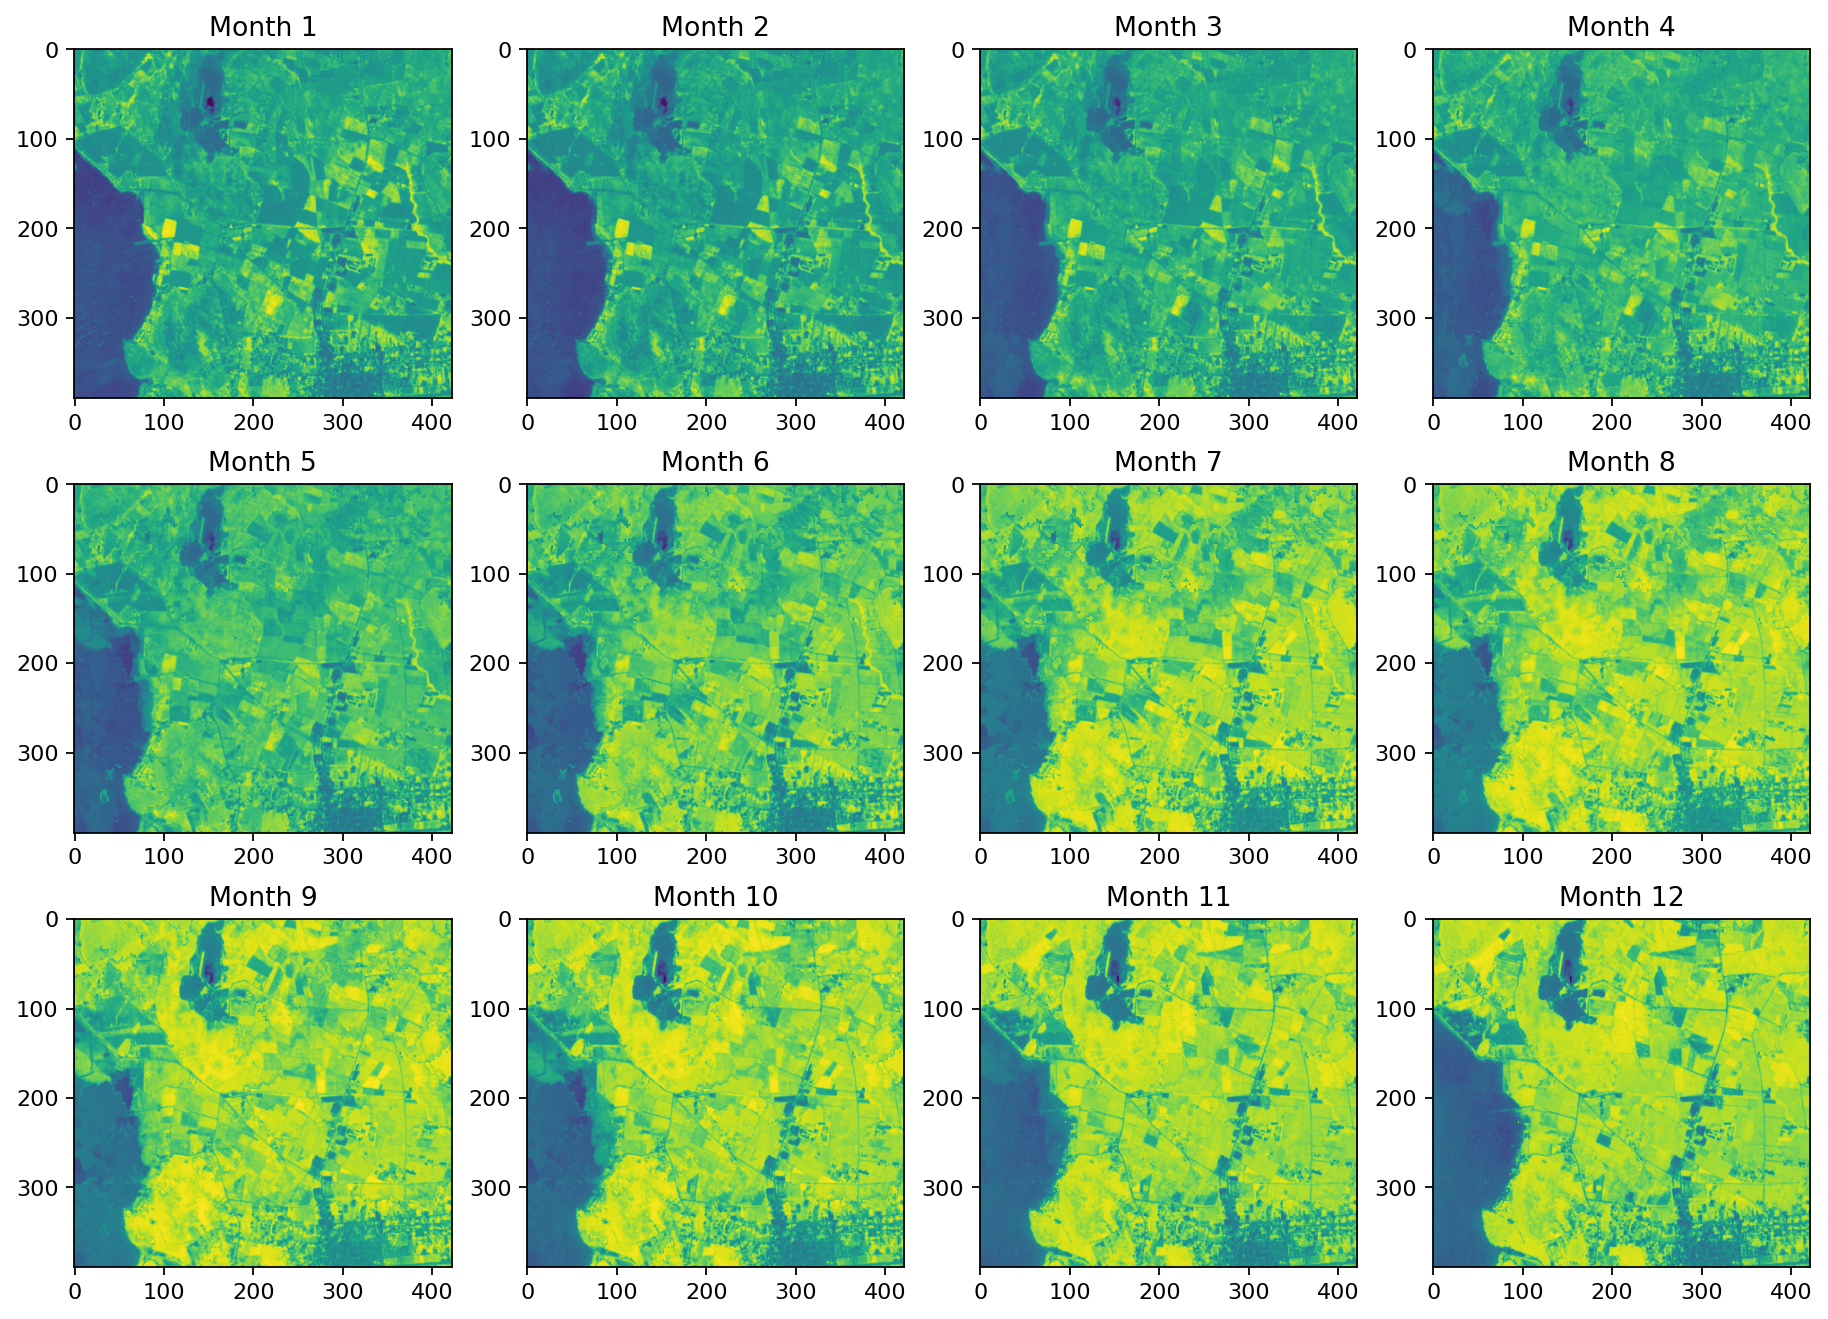

In [31]:
# Try show image

select_index = 0

fig, axs = plt.subplots(3, 4, figsize = (14, 10), dpi=160)

axs = axs.flatten()

for i in range(len(axs)):
    
    axs[i].imshow(datacube[:, :, i, select_index])
    axs[i].set_title(f'Month {i+1}')

As above, you check the shape of the dataset, it is `(height, width, seq, feature)` which is not related to the shape we trained the model that requires the shape of intput is `(batch, feature, seq)` which `batch` denotes to `height*width` flattened. First to make the model can inference the dataset. we should transpose to switch the axis `features` with `seq`

In [95]:
datacube = datacube.transpose(0,1,3,2)

datacube.shape

(390, 422, 8, 12)

Now the datacibe is ready to inference mapping the LULC map data. The step is to prepare the input of the model, retrieve the model and inference.

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

Since our model is pixel-based prediction, we need to flatten the `height` and `width` axis into a single row. On the other hand, we must reshape the result back to the original shape of map. So that, we should have some variables to save this shape information

In [97]:
n_pixel = datacube.shape[0]*datacube.shape[1]

image_height = datacube.shape[0]
image_width = datacube.shape[1]

Then reshape the `datacube` and place in `X`

In [99]:
X = datacube.reshape(n_pixel, 8, 12)

In real inferencing, we might works with large image of preidiction which the machine could not handle the whole image at a time. We can do batching as training. By this, we split the pixel row to a chunk which stands for `batch_size`.

In [100]:
def chunk_array(array, chunk_size):
    
    return [array[i:i + chunk_size] for i in range(0, len(array), chunk_size)]

Implement the `X` to chunked `X_loader`

In [101]:
X_loader = chunk_array(X, chunk_size=128)

We get the `X_loader` with this number of batches

In [102]:
len(X_loader)

1286

Which each batch has this shape of data. The first axis is the `chunk_size` as we define

In [103]:
next(iter(X_loader)).shape

(128, 8, 12)

We mentioned in previous lesson that the model we save is only `state_dict` which save only weights of model. To retreive the model, we create an instance if model then `model.load_state_dict()` to retreive the saved weights. This way is practical in real usage to prevent any mistakes. Therefore, declare the model structure as same as in training lesson.

<br>

__Noted that the model class structure must be same as training__

In [114]:
# Define the model
class CNN1DModelReg(nn.Module):
    
    def __init__(self, input_features, num_classes, timesteps):
        super(CNN1DModelReg, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.relu = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(384, 512)  # Assuming timesteps are halved by pooling
        
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.flatten(x)
        
        #print(x.shape)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        
        return x

As well as the model instantiation, the any configuration should be same, Then apply `load_state_dict` from file

In [ ]:
!curl -L --output "model_1dcnn-reg_8f12t.pt" "https://github.com/thanthamky/rs-lc-dl/raw/refs/heads/main/model_1dcnn-reg_8f12t.pt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


Case of run on Colab, run above cell first to download a model file

In [125]:
model = CNN1DModelReg(input_features=8, num_classes=8, timesteps=12)

model.load_state_dict(torch.load('model_1dcnn-reg_8f12t.pt', weights_only=True))

<All keys matched successfully>

To use model in inferencing step, set the model to `eval()` mode to disable any regularized layers

In [126]:
model.eval()

CNN1DModelReg(
  (conv1): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
)

For each `x` chunk in `X_loader`, we feedforward to get the output and use `torch.max` to get the class

In [128]:
predictions = []

for chunk in tqdm(X_loader):
    
    x = torch.from_numpy(chunk).float()
    
    out = model(x)
    
    _, pred = torch.max(out, axis=1)
    
    predictions.extend([pred])

100%|██████████| 1286/1286 [00:04<00:00, 320.88it/s]


The prediction above is to place the `x` in a list, what we have to do is concatenate every prediction results to a single row as number of pixels

In [129]:
y = torch.cat(predictions)

y.shape

torch.Size([164580])

The output is a row of all pixels flattened. we need to reshape it back to original map dimensions

In [130]:
lulc = y.reshape(image_height, image_width)

lulc.shape

torch.Size([390, 422])

See our acheivement

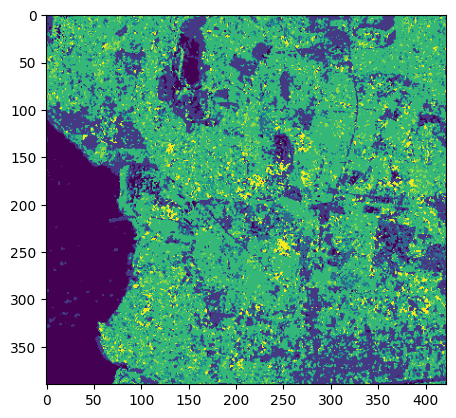

In [131]:
plt.imshow(lulc)

There is another step that we could not ignore. It is to save the map resultto GeoTIFF data. Convert the torch output to `numpy.ndarray` first

In [132]:
lulc_np = lulc.numpy()

To save the result, we need some metadata of raster profile to geo-referenced image data. So we choose one of the image we have to load `src.profile` out from the file

In [133]:
with rasterio.open(base_path+'inference_dataset/ndvi/2_S2A_MSIL2A_20210218T034811_N0214_R104_T47PNS_20210218T073728_NDVI.tif') as src:
    
    raster_profile = src.profile
    
raster_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 422, 'height': 390, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]'), 'transform': Affine(10.0, 0.0, 571330.0,
       0.0, -10.0, 1644690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

We see that it is a dictionary-based allowing us to modify. If you see roughly, there is a property to change. It is the dtype. So we update the `dtype` to be same as `lulc_np` `dtype`

In [58]:
raster_profile.update({'dtype': lulc_np.dtype})

raster_profile

{'driver': 'GTiff', 'dtype': dtype('int64'), 'nodata': -9999.0, 'width': 422, 'height': 390, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]'), 'transform': Affine(10.0, 0.0, 571330.0,
       0.0, -10.0, 1644690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

Then we can save this data into a GeoTIFF file

In [50]:
with rasterio.open('lulc_map_1dcnn-reg.tif', 'w', **raster_profile) as dest:
    
    dest.write(lulc_np[np.newaxis,:,:])

## Application (Bonus)

This is a special section that show that we can also visualize interactive-map with our LULC map data we already classified. This helps in various ways to do any interactive visualization with raster data and vector data. See [leafmap](https://leafmap.org/)

In [134]:
import leafmap

Create instance of leafmap

In [135]:
m = leafmap.Map()

Add a raster file

In [136]:
m.add_raster(base_path+'lulc_map_1dcnn-reg.tif')

Show map

In [137]:
m

Map(center=[14.8580675, 99.6826545], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…